In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph faiss-cpu

## Graph

Lay out LCEL-teacher in LangGraph with two code checks:

1. Check imports
2. Check code execution

---

Open questions:

1. How to handle pseudo-code that is still valid (e.g., file names that don't exist)?
2. How to handle infinite looping (stop condition)?
3. How to handle questions out-of-scope for LCEL? Routing for chat-LangChain.
4. How to handle packages? User env may not have all the needed pkgs. Feedback may catch this and do `pip install`.

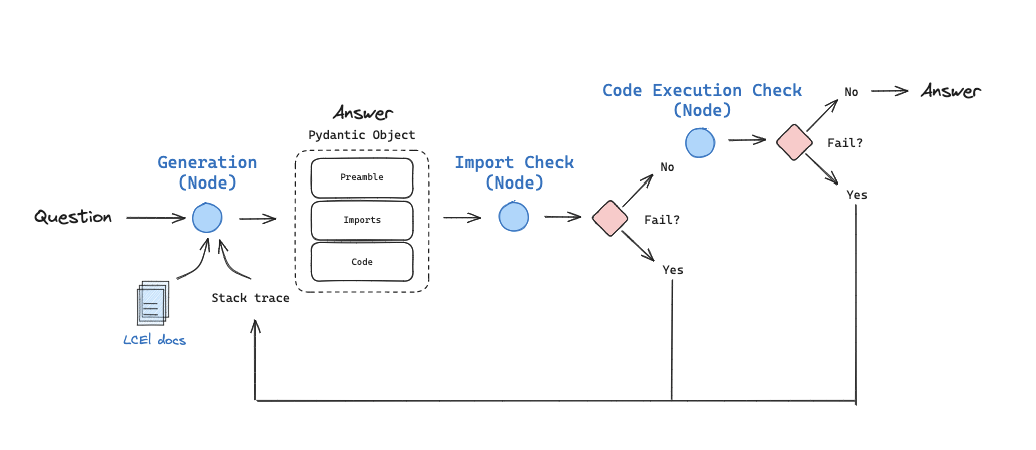

## State 

In [10]:
from typing import Dict, TypedDict

from langchain_core.messages import BaseMessage


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

## Graph 

In [65]:
from operator import itemgetter
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.utils.function_calling import convert_to_openai_tool

def generate(state):
    """
    Generate a code solution based on LCEL docs and the input question 
    with optional feedback from code execution tests 

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    
    ## State
    state_dict = state["keys"]
    question = state_dict["question"]
    
    ## Context 
    # LCEL docs
    url = "https://python.langchain.com/docs/expression_language/"
    loader = RecursiveUrlLoader(
        url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
    )
    docs = loader.load()
    
    # LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
    url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
    loader = RecursiveUrlLoader(
        url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
    )
    docs_pydantic = loader.load()
    
    # LCEL w/ Self Query (outside the primary LCEL docs)
    url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
    loader = RecursiveUrlLoader(
        url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
    )
    docs_sq = loader.load()
    
    # Add 
    docs.extend([*docs_pydantic, *docs_sq])
    
    # Sort the list based on the URLs in 'metadata' -> 'source'
    d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
    d_reversed = list(reversed(d_sorted))
    
    # Concatenate the 'page_content' of each sorted dictionary
    concatenated_content = "\n\n\n --- \n\n\n".join(
        [doc.page_content for doc in d_reversed]
    )
    
    ## Data model
    class code(BaseModel):
        """Code output"""
        prefix: str = Field(description="Description of the problem and approach")
        imports: str = Field(description="Code block import statements")
        code: str = Field(description="Code block not including import statements")
    
    ## LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    
    # Tool
    code_tool_oai = convert_to_openai_tool(code)
    
    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(code_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "code"}},
    )
    
    # Parser
    parser_tool = PydanticToolsParser(tools=[code])
    
    ## Prompt
    template = """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
        Here is a full set of LCEL documentation: 
        \n ------- \n
        {context} 
        \n ------- \n
        Answer the user question based on the above provided documentation. \n
        Ensure any code you provide can be executed with all required imports and variables defined. \n
        Structure your answer with a description of the code solution. \n
        Then list the imports. And finally list the functioning code block. \n
        Here is the user question: \n --- --- --- \n {question}"""

    ## Generation
    if "error" in state_dict:
        print("---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---")
        
        error = state_dict["error"]
        code_solution = state_dict["generation"]
        
        # Udpate prompt 
        addendum = """  \n --- --- --- \n You previously tried to solve this problem. \n Here is your solution:  
                    \n --- --- --- \n {generation}  \n --- --- --- \n  Here is the resulting error from code 
                    execution:  \n --- --- --- \n {error}  \n --- --- --- \n Please re-try to answer this. 
                    Structure your answer with a description of the code solution. \n Then list the imports. 
                    And finally list the functioning code block. Structure your answer with a description of 
                    the code solution. \n Then list the imports. And finally list the functioning code block. 
                    \n Here is the user question: \n --- --- --- \n {question}"""
        template = template +  addendum

        # Prompt 
        prompt = PromptTemplate(
            template=template,
            input_variables=["context", "question", "generation", "error"],
        )
        
        # Chain
        chain = (
            {
                "context": lambda x: concatenated_content,
                "question": itemgetter("question"),
                "generation": itemgetter("generation"),
                "error": itemgetter("error"),
            }
            | prompt
            | llm_with_tool 
            | parser_tool
        )

        code_solution = chain.invoke({"question":question,
                                      "generation":str(code_solution[0]),
                                      "error":error})
                
    else:
        print("---GENERATE SOLUTION---")
        
        # Prompt 
        prompt = PromptTemplate(
            template=template,
            input_variables=["context", "question"],
        )

        # Chain
        chain = (
            {
                "context": lambda x: concatenated_content,
                "question": itemgetter("question"),
            }
            | prompt
            | llm_with_tool 
            | parser_tool
        )

        code_solution = chain.invoke({"question":question})
    
    return {"keys": {"generation": code_solution, "question": question}}

def check_code_imports(state):
    """
    Check imports

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """
    
    ## State
    print("---CHECKING CODE IMPORTS---")
    state_dict = state["keys"]
    question = state_dict["question"]
    code_solution = state_dict["generation"]
    imports = code_solution[0].imports

    try:        
        # Attempt to execute the imports
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        # Catch any error during execution (e.g., ImportError, SyntaxError)
        error = f"Execution error: {e}"
        if "error" in state_dict:
            error_prev_runs = state_dict["error"]
            error = error_prev_runs + "\n --- Most recent run error --- \n" + error     
    else:
        print("---CODE IMPORT CHECK: SUCCESS---")
        # No errors occurred
        error = "None"

    return {"keys": {"generation": code_solution, "question": question, "error": error}}

def check_code_execution(state):
    """
    Check code block execution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """
    
    ## State
    print("---CHECKING CODE EXECUTION---")
    state_dict = state["keys"]
    question = state_dict["question"]
    code_solution = state_dict["generation"]
    imports = code_solution[0].imports
    code = code_solution[0].code
    code_block = imports +"\n"+ code

    try:        
        # Attempt to execute the code block
        exec(code_block)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        # Catch any error during execution (e.g., ImportError, SyntaxError)
        error = f"Execution error: {e}"
        if "error" in state_dict:
            error_prev_runs = state_dict["error"]
            error = error_prev_runs + "\n --- Most recent run error --- \n" + error  
    else:
        print("---CODE BLOCK CHECK: SUCCESS---")
        # No errors occurred
        error = "None"

    return {"keys": {"generation": code_solution, "question": question, "error": error}}


### Edges

def decide_to_check_code_exec(state):
    """
    Determines whether to test code execution, or re-try answer generation.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    question = state_dict["question"]
    code_solution = state_dict["generation"]
    error = state_dict["error"]

    if error == "None":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TEST CODE EXECUTION---")
        return "check_code_execution"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

def decide_to_finish(state):
    """
    Determines whether to finish.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    question = state_dict["question"]
    code_solution = state_dict["generation"]
    error = state_dict["error"]

    if error == "None":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TEST CODE EXECUTION---")
        return "end"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

In [66]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code_imports", check_code_imports)  # check imports
workflow.add_node("check_code_execution", check_code_execution)  # check execution

# Build graph
workflow.set_entry_point("generate")
workflow.add_edge("generate", "check_code_imports")
workflow.add_conditional_edges(
    "check_code_imports",
    decide_to_check_code_exec,
    {
        "check_code_execution": "check_code_execution",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "check_code_execution",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate",
    },
)

# Compile
app = workflow.compile()

## Test

* [Here](https://docs.google.com/spreadsheets/d/1SkHHw52AHFFBnmljKW3Vq_YvnPpAhhBVhd1SF9mPFUk/edit#gid=488086028) are eval questions
  
### Sanity check

* Start with a question that we know is typically correct.
* Trace: https://smith.langchain.com/public/2185b75c-5888-4afd-8aef-7664b397fc38/r

In [29]:
# Run
import pprint
inputs = {"keys": {"question": "How can I build a RAG chain in LCEL?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value['keys']['generation'])

---GENERATE SOLUTION---
"Node 'generate':"
'\n---\n'
---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
"Node 'check_code_imports':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
---CHECKING CODE IMPORTS---
Harrison worked at Kensho.
---CODE BLOCK CHECK: SUCCESS---
"Node 'check_code_execution':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
"Node '__end__':"
'\n---\n'
[code(prefix='To build a Retrieval-Augmented Generation (RAG) chain in LangChain Expression Language (LCEL), you can follow this approach. This example demonstrates how to create a RAG chain that combines a retrieval step with a prompt and language model to generate a response based on retrieved context. \n\n', imports='from operator import itemgetter\nfrom langchain_community.vectorstores import FAISS\nfrom langchain_core.output_parsers import StrOutputParser\nfrom langchain_core.prompts import ChatPromptTemplate\nfrom langchain_core.runnab

### Hard

Test 3 quetions that failed w/ initial version (no inline code check and re-try). See [here](https://docs.google.com/spreadsheets/d/1SkHHw52AHFFBnmljKW3Vq_YvnPpAhhBVhd1SF9mPFUk/edit#gid=488086028).

`Question 1`
* Trace: https://smith.langchain.com/public/2981c3c9-7583-47da-82ca-c9caba1a0587/r

In [49]:
# Run
question = """I am passing text key 'foo' to my prompt and want to process it with a function, process_text(...), prior to the prompt. 
              How can I do this using LCEL?"""
inputs = {"keys": {"question": question}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value['keys']['generation'])

---GENERATE SOLUTION---
"Node 'generate':"
'\n---\n'
---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
"Node 'check_code_imports':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
---CHECKING CODE EXECUTION---
---CODE BLOCK CHECK: FAILED---
"Node 'check_code_execution':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: RE-TRY SOLUTION---
---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---
"Node 'generate':"
'\n---\n'
---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
"Node 'check_code_imports':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
---CHECKING CODE EXECUTION---
content='LCEL (Low-Carbon Energy and Lifestyles) processed refers to a method of producing energy and products that aims to reduce carbon emissions and promote sustainable living practices. This process typically involves using renewable energy sources such as solar, wind, and hydropower, as well as implementing energy-efficien

`Question 2`

* Trace: https://smith.langchain.com/public/16b62ab3-0a79-46b0-b63e-7e6462ef94cc/r

In [67]:
# Run
question = """How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"""
inputs = {"keys": {"question": question}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value['keys']['generation'])

---GENERATE SOLUTION---
"Node 'generate':"
'\n---\n'
---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
"Node 'check_code_imports':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
---CHECKING CODE EXECUTION---
---CODE BLOCK CHECK: FAILED---
"Node 'check_code_execution':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: RE-TRY SOLUTION---
---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---
"Node 'generate':"
'\n---\n'
---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
"Node 'check_code_imports':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
---CHECKING CODE EXECUTION---
Why don't cats play poker in the wild?
Too many cheetahs!
---CODE BLOCK CHECK: SUCCESS---
"Node 'check_code_execution':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
"Node '__end__':"
'\n---\n'
[code(prefix="To directly pass a string to a runnable and use it to construct the input needed for

`Question 3`

* Trace: https://smith.langchain.com/public/925c9ab4-344f-4d6f-baff-325b898a6ad5/r

In [68]:
# Run
question = """How can I use a custom function to route between 2 chains in LCEL?"""
inputs = {"keys": {"question": question}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value['keys']['generation'])

---GENERATE SOLUTION---
"Node 'generate':"
'\n---\n'
---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
"Node 'check_code_imports':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
---CHECKING CODE EXECUTION---
---CODE BLOCK CHECK: FAILED---
"Node 'check_code_execution':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: RE-TRY SOLUTION---
---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---
"Node 'generate':"
'\n---\n'
---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
"Node 'check_code_imports':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
---CHECKING CODE EXECUTION---
---CODE BLOCK CHECK: FAILED---
"Node 'check_code_execution':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: RE-TRY SOLUTION---
---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---
"Node 'generate':"
'\n---\n'
---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
"Node 'check_code_imports':"
'\n---\n'
---DECIDE TO TE

GraphRecursionError: Recursion limit of 25 reachedwithout hitting a stop condition. You can increase the limitby setting the `recursion_limit` config key.

## Manual review

In [69]:
code_block = value['keys']['generation'][0]

In [70]:
code_block.prefix

"To route between two chains in LCEL based on a custom function, you can use the `RunnableLambda` component. This component allows you to define a function that, given an input, returns a specific `Runnable` (chain) to execute. Here's how you can implement this:\n\n"

In [71]:
code_block.imports

'from langchain_core.runnables import RunnableLambda\nfrom langchain_core.prompts import ChatPromptTemplate\nfrom langchain_openai import ChatOpenAI\nfrom langchain_core.output_parsers import StrOutputParser'

In [72]:
exec(code_block.imports)

In [73]:
code_block.code

'# Define two different chains\nprompt1 = ChatPromptTemplate.from_template("Tell me a joke about {topic}")\nmodel1 = ChatOpenAI()\nchain1 = prompt1 | model1 | StrOutputParser()\n\nprompt2 = ChatPromptTemplate.from_template("Write a short poem about {topic}")\nmodel2 = ChatOpenAI()\nchain2 = prompt2 | model2 | StrOutputParser()\n\n# Define a custom function to route between the two chains based on input\ndef route_based_on_input(input):\n    if "joke" in input["query"].lower():\n        return chain1\n    else:\n        return chain2\n\n# Use RunnableLambda to apply the routing function\nrouter = RunnableLambda(route_based_on_input)\n\n# Example usage\n# Assuming the input is a dictionary with a \'query\' key\ninput_data = {"query": "Tell me a joke about cats"}\nresult_chain = router.invoke(input_data)\n# Execute the selected chain\nresult = result_chain.invoke(input_data)\nprint(result)'

In [74]:
exec(code_block.code)

KeyError: "Input to ChatPromptTemplate is missing variables {'topic'}.  Expected: ['topic'] Received: ['query']"

In [76]:
# Define two different chains

prompt1 = ChatPromptTemplate.from_template("Tell me a joke about {topic}")
model1 = ChatOpenAI()
chain1 = prompt1 | model1 | StrOutputParser()

prompt2 = ChatPromptTemplate.from_template("Write a short poem about {topic}")
model2 = ChatOpenAI()
chain2 = prompt2 | model2 | StrOutputParser()

# Define a custom function to route between the two chains based on input

def route_based_on_input(input):
    if "joke" in input["query"].lower():
        return chain1
    else:
        return chain2

# Use RunnableLambda to apply the routing function
router = RunnableLambda(route_based_on_input)

# Example usage
# Assuming the input is a dictionary with a \'query\' key\n

input_data = {"query": "Tell me a joke about cats"}
result_chain = router.invoke(input_data)
# Execute the selected chain
result = result_chain.invoke(input_data)

KeyError: "Input to ChatPromptTemplate is missing variables {'topic'}.  Expected: ['topic'] Received: ['query']"